ABSTRACT

Parkinson's Disease (PD) affects millions of people worldwide, and currently there is no known cure. The International Parkinson and Movement Disorder Society (MDS) came up with an Unified Parkinson's Disease Rating Scale (UPDRS) for doctors to better understand the severity of a patient's disease progression. Our current knowledge of PD suggests that it is correlated to the presence (and concentration) of certain proteins and peptides in their cerebral spinal fluid (CSF). A Kaggle competition asks participants to use machine learning to predict UPDRS scores from their several years' PD medical data collected from several hundreds of patients. 

The winning competitors all chose to not use the proteomic data (i.e. protein and peptide concentrations in the CSF) but instead predicted UPDRS scores purely based on the patients' patterns of visitation to the doctor's office. While this loophole allowed for some unintended winning models, they did not address the original scientific intent of the competition - to predict a patient's UPDRS score (i.e. their PD status) based on ther proteomic data. Such a correlation, if found, would be scientifically significant and medically relevant. As UPDRS scores are strictly survey-based and are thus inherently subjective, a more scientific way to measure disease severity via proteomic data would be a major step foward in the study of PD.

My solution involves training Decision Tree Regressors on the 2000+ different proteins and peptides as features, and to predict their corresponding UPDRS scores with the lowest Mean Absolute Error (MAE). The competition uses Squared Mean Absolute Percentage Error (SMAPE) as its judging metric, so it is included in the model evaluation as well. In the case of both MAE and SMAPE, a lower score means a better prediction. 

The results are very promising - my model is able to predict UPDRS scores (there are four parts: UPDRS_1, _2, _3, _4) with an MAE between 0.7 and 5 (on an UPDRS scale of 0-72). My models scored between 31 and 51 with SMAPE (meaning ~15% to ~25% errors), whereas in the competition the winning SMAPE scores were on average 59 (~30% error). 

INTRODUCTION

Parkinson's Disease (PD) is a progressive and degenerative disease of the central nervous system (CNS). Symptoms emerge slowly and worsen over time, and cell death takes place mostly in a central part of the brain known as the basal ganglia. This leads to noticeable movement symptoms like tremor, slow movement, rigidity and poor balance, and later on also cognitive decline and memory problems. The life expectancy is roughly 7-15 years from the date of diagnosis. It typically affects people over the age of 60, and men much more than women (at a ratio of 3:1). By 2040 we are expected to have over 14 million people worldwide affected by PD, and to this day there is no known cure.

The MDS is the International Parkinson and Movement Disorder Society. MDS-UPDRS stands for the MDS Unified Parkinson's Disease Rating Scale, and it is the most up-to-date international gold standard scoring system for rating the severity of Parkinson’s presentation in a patient. The scale has 4 parts, as summarized in this project proposal. The lower the score, the lesser the severity of disease presentation. It is worth mentioning that UPDRS is designed to allow scientists and clinicians to get a general idea on their patients’ disease progression. Seeing that it is a survey-based scoring system, it is not meant to be taken in the sense of strict and objective scientific accuracy, like that of a blood test. 

add a paragraph explaining proteomic data as relevant to PD.

The Kaggle competition provided CSV files of patient medical data that included patient ID's, time stamps, proteomic information, and UPDRS scores. In trying to come up with the lowest SMAPE scores (and thus winning the competition), many participants ignored the proteomic data because their models were faring better without it. While this did not break the rules of the competition, the organizers came out voicing their wish to see further models trained with the proteomic data. 

My model, which is an ADABoostRegressor trained on the proteomic data, is able to predict UPDRS scores with the following results: 

updrs_1: 
MAE: 2.4933078393881454; SMAPE: 49.836658805699805

updrs_2: 
MAE: 2.1816443594646273; SMAPE: 51.087518014659125

updrs_3: 
MAE: 5.084130019120459; SMAPE: 47.72410907259874

updrs_4: 
MAE: 0.7418788234644665; SMAPE: 31.460652181546784




METHODOLOGY

a paragraph here - an overview on my approach.

The steps I took are as follows:
1) Understanding the data.
2) Cleaning and organizing the data. 
3) Training and testing different models for an initial impression and comparison. 
4) Selecting a few high-performing models for further testing and comparison, while doing parameter searching.
5) Finalizing the best-performing model for parameter hypertuning for the best results.

Data Looking and Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from pathlib import Path

First I load the datasets as Pandas dataframes.

In [2]:
# Load the competition datasets into Pandas DataFrame
path = Path("/Users/13392/Documents/amp-parkinsons-disease-progression-prediction")
train_proteins = pd.read_csv(path/"train_proteins.csv")
train_peptides = pd.read_csv(path/"train_peptides.csv")
train_clinical = pd.read_csv(path/"train_clinical_data.csv")
supplemental_clinical = pd.read_csv(path/"supplemental_clinical_data.csv")

To get a rough idea of the size of datasets that I am dealing with:

In [3]:
print(train_clinical.shape)
print(train_peptides.shape)
print(train_proteins.shape)
print(supplemental_clinical.shape)

(2615, 8)
(981834, 6)
(232741, 5)
(2223, 8)


To see what the datasets actually look like:

In [4]:
train_clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [5]:
train_peptides.head(20)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
5,55_0,0,55,O00533,TLKIENVSYQDKGNYR,23216.50
6,55_0,0,55,O00533,VIAVNEVGR,170878.00
7,55_0,0,55,O00533,VMTPAVYAPYDVK,148771.00
8,55_0,0,55,O00533,VNGSPVDNHPFAGDVVFPR,55202.10
9,55_0,0,55,O00584,ELDLNSVLLK,27229.30


In [6]:
train_proteins.head(10)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.30
1,55_0,0,55,O00533,732430.00
2,55_0,0,55,O00584,39585.80
3,55_0,0,55,O14498,41526.90
4,55_0,0,55,O14773,31238.00
5,55_0,0,55,O14791,4202.71
6,55_0,0,55,O15240,177775.00
7,55_0,0,55,O15394,62898.20
8,55_0,0,55,O43505,333376.00
9,55_0,0,55,O60888,166850.00


In [7]:
supplemental_clinical.head(10)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN
5,337_0,337,0,5.0,7.0,6.0,0.0,On
6,337_36,337,36,8.0,7.0,8.0,0.0,On
7,527_0,527,0,6.0,2.0,9.0,0.0,NaN
8,527_36,527,36,2.0,18.0,22.0,0.0,On
9,557_0,557,0,5.0,6.0,22.0,0.0,NaN


Observations: 
1) The columns are: visit_id, patient_id, visit_month, updrs_1, updrs_2, updrs_3, updrs_4, medication status (upd23b_clinical_state_on_medication), protein ID (UniProt), protein concentration (NPX), peptide ID (Peptide), peptide concentration (PeptideAbundance). 

2) visit_id = patient_id + visit_month

3) NaN values will need to be dealt with. 

4) Visits seem to be made and recorded every few months for "clinical data", while in "supplemental data" a visit is recorded only every 36 months. 

5) Each patient has many rows of data, except in "supplemntal data" there is only one or two rows ('visits') for each patient. 


To understand how many patients we have in the datasets:

In [8]:
# Determining the number of unique patients in the datasets.

clinical_patient_count = train_clinical['patient_id'].nunique()
print(f'There are {clinical_patient_count} number of unique patients in "train_clinical_data.csv"')

patient_count1 = train_peptides['patient_id'].nunique()
print(f'There are {patient_count1} number of unique patients in "train_peptides.csv"')

patient_count2 = train_proteins['patient_id'].nunique()
print(f'There are {patient_count2} number of unique patients in "train_proteins.csv"')
      
supplemental_patient_count = supplemental_clinical['patient_id'].nunique()
print(f'There are {supplemental_patient_count} number of unique patients in "supplemental_clinical_data.csv"')

There are 248 number of unique patients in "train_clinical_data.csv"
There are 248 number of unique patients in "train_peptides.csv"
There are 248 number of unique patients in "train_proteins.csv"
There are 771 number of unique patients in "supplemental_clinical_data.csv"


As we can see, all 248 "clinical" patients have recorded proteomic (protein and peptide) data, while as the 771 "supplemental" patients have no proteomic data at all. Although the "supplemental" dataset provides many extra patients, there is no proteomic data. Whether this supplemental dataset will help the models is very questionable.

In [9]:
# list all the unique patient_id's
train_clinical['patient_id'].unique()

array([   55,   942,  1517,  1923,  2660,  3636,  3863,  4161,  4172,
        4923,  5027,  5036,  5178,  5645,  5742,  6054,  6211,  6420,
        7051,  7117,  7151,  7265,  7508,  7568,  7832,  7886,  8344,
        8699, 10053, 10138, 10174, 10541, 10715, 10718, 11459, 11686,
       11928, 12516, 12636, 12703, 12755, 12931, 13360, 13368, 13618,
       13804, 13852, 13968, 14035, 14124, 14242, 14270, 14344, 14450,
       14811, 15009, 15245, 15504, 15590, 16238, 16347, 16566, 16574,
       16778, 16931, 17154, 17201, 17414, 17727, 18183, 18204, 18553,
       18560, 19088, 20212, 20216, 20352, 20404, 20460, 20581, 20664,
       20707, 20791, 20792, 21126, 21537, 21729, 22126, 22623, 23175,
       23192, 23244, 23391, 23636, 24278, 24690, 24818, 24820, 24911,
       25562, 25739, 25750, 25827, 25911, 26005, 26104, 26210, 26809,
       27079, 27300, 27464, 27468, 27607, 27715, 27872, 27893, 27971,
       27987, 28327, 28342, 28818, 29313, 29417, 30119, 30155, 30416,
       30894, 30951,

Let's take a look at the complete data for a single patient.

In [10]:
# Look at all the available clincal data for one patient: patient_id = 55
train_clinical[train_clinical['patient_id']==55]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [11]:
# Look at all the available clincal data for another patient: patient_id = 942
train_clinical[train_clinical['patient_id']==942]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
13,942_0,942,0,3.0,2.0,20.0,NaN,NaN
14,942_3,942,3,7.0,2.0,17.0,NaN,NaN
15,942_6,942,6,8.0,2.0,21.0,NaN,NaN
16,942_12,942,12,5.0,2.0,25.0,0.0,NaN
17,942_18,942,18,6.0,5.0,18.0,0.0,NaN
18,942_24,942,24,2.0,3.0,23.0,NaN,NaN
19,942_30,942,30,4.0,4.0,19.0,0.0,NaN
20,942_36,942,36,2.0,4.0,19.0,0.0,NaN
21,942_42,942,42,2.0,3.0,32.0,0.0,NaN
22,942_48,942,48,2.0,6.0,35.0,0.0,NaN


In [12]:
# Look at all the avaiable clincal data for another patient: patient_id = 1517
train_clinical[train_clinical['patient_id']==1517]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
28,1517_0,1517,0,11.0,6.0,25.0,5.0,On
29,1517_6,1517,6,17.0,4.0,30.0,7.0,On
30,1517_12,1517,12,20.0,11.0,32.0,5.0,On
31,1517_18,1517,18,23.0,14.0,25.0,5.0,On
32,1517_24,1517,24,19.0,11.0,28.0,3.0,On
33,1517_30,1517,30,20.0,15.0,39.0,10.0,Off
34,1517_36,1517,36,20.0,17.0,31.0,8.0,On
35,1517_42,1517,42,15.0,13.0,37.0,4.0,On
36,1517_48,1517,48,20.0,18.0,40.0,6.0,Off
37,1517_60,1517,60,19.0,18.0,39.0,10.0,Off


I notice a lot of NaN values in the previous patient data, especially in 'clinical_state_on_medication' column, so let's count all the NaN values in each column.

In [13]:
train_clinical.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [14]:
# counting the number of unique scores for 'clinical state on medication' and their occurances.

train_clinical['upd23b_clinical_state_on_medication'].value_counts()

On     775
Off    513
Name: upd23b_clinical_state_on_medication, dtype: int64

Out of 2615 entries for each column, "upd23b_clinical_state_on_medication" has over 50% of of the values as NaN. Since it's indication whether a patient is either "on" or "off" medication, there is no straight forward way to interpolate the missing values. Furthermore, the competition organizers have stated that the testing dataset does not contain any information on medication status. 

I'm going to drop the column entirely later when I am preparing the dataset for training, especially considering that the testing data will not have any medication data. 

Now I will look at the proteomic datasets. First I will look at how much data is missing, because this is the first problem that I will need to deal with. Most machine learning models do not deal with NaN values, with XGBoost models being the notable exceptions. 

In [15]:

train_peptides.isna().sum()

visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64

In [16]:
train_proteins.isna().sum()

visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64

The good news is that the protein and peptide datasets seem to have no missing values.

Let's take a look at the clinical and supplemental datasets more closely, this time from a statistical angle. 

In [17]:
cols = ['visit_month','updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
train_clinical[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,2615.0,31.190822,25.199053,0.0,10.5,24.0,48.0,108.0
updrs_1,2614.0,7.110559,5.525955,0.0,3.0,6.0,10.0,33.0
updrs_2,2613.0,6.743590,6.323230,0.0,1.0,5.0,10.0,40.0
updrs_3,2590.0,19.421236,15.000289,0.0,6.0,19.0,29.0,86.0
updrs_4,1577.0,1.861763,3.022112,0.0,0.0,0.0,3.0,20.0


Here we see the distribution of UPDRS scores, as well as the number of months that the patients are followed up for. 

UPDRS_1: 0-33, UPDRS_2: 0-40; UPDRS_3: 0-86; UPDRS_4: 0-20.

visit_month: 0-108, with an average of 31 months. 

std is the standard deviation, and the "25%", "50%" and "75%" columns are the corresponding percentile UPDRS scores. 

In [18]:
supplemental_clinical[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,2223.0,12.910481,13.060532,0.0,0.0,6.0,24.0,36.0
updrs_1,2010.0,5.684080,4.366964,0.0,2.0,5.0,8.0,27.0
updrs_2,2009.0,6.507715,4.968132,0.0,2.0,5.0,10.0,34.0
updrs_3,2218.0,22.917944,12.342596,0.0,14.0,22.0,31.0,72.0
updrs_4,1295.0,0.840154,1.860247,0.0,0.0,0.0,0.0,12.0


The longest duration of follow-up for patients in "clinical Data" is 108 months, and for patients in "supplemental data" is 36 months.

Let's see how many of the 'clinical' patients are followed up for 56 months (mean + 1 std) or more, and how many of the 'supplemental' patients are followed up for 36 months (max). This is useful information because a higher number of follow-ups would mean more data points for that patient, and thus more data for the models to learn on.

In [19]:
months_followed = 56
unique_pt_count = train_clinical[train_clinical['visit_month']>=months_followed]['patient_id'].nunique()

In [20]:
unique_pt_count_suppl = supplemental_clinical[supplemental_clinical['visit_month']>=36]['patient_id'].nunique()

In [21]:
print(f'{unique_pt_count/clinical_patient_count*100:.2f}% in the clinical data are follwed up for 56 months or more.')
print(f'{unique_pt_count_suppl/supplemental_patient_count*100:.2f}% in the supplemental data are follwed up for 36 months.')

68.95% in the clinical data are follwed up for 56 months or more.
33.46% in the supplemental data are follwed up for 36 months.


I am going to combine the datasets, and plot them on a graph.

In [22]:
# label the source of data before combining them.
train_clinical['source'] = 'Clinical Data'
supplemental_clinical['source'] = 'Supplemental Data'

combined_data = pd.concat([train_clinical, supplemental_clinical],ignore_index=True)

In [23]:
combined_data

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,source
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,Clinical Data
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,Clinical Data
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,Clinical Data
3,55_9,55,9,8.0,9.0,30.0,0.0,On,Clinical Data
4,55_12,55,12,10.0,10.0,41.0,0.0,On,Clinical Data
...,...,...,...,...,...,...,...,...,...
4833,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN,Supplemental Data
4834,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN,Supplemental Data
4835,65405_5,65405,5,NaN,NaN,57.0,NaN,NaN,Supplemental Data
4836,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN,Supplemental Data


In [24]:
# check the total number of patients in the combined data. 
combined_data['patient_id'].nunique()

1019

There are no overlapping patients between the two datasets, hence the supplemental dataset (which contains no proteomic data) adds no additional value to the main clinical dataset. Since models rely on all datapoints having the same features, one can perhaps understand why some competitors chose to not use proteomic data at all, because that would add more than 700 patients for model training. 

Now for a graphical comparison:

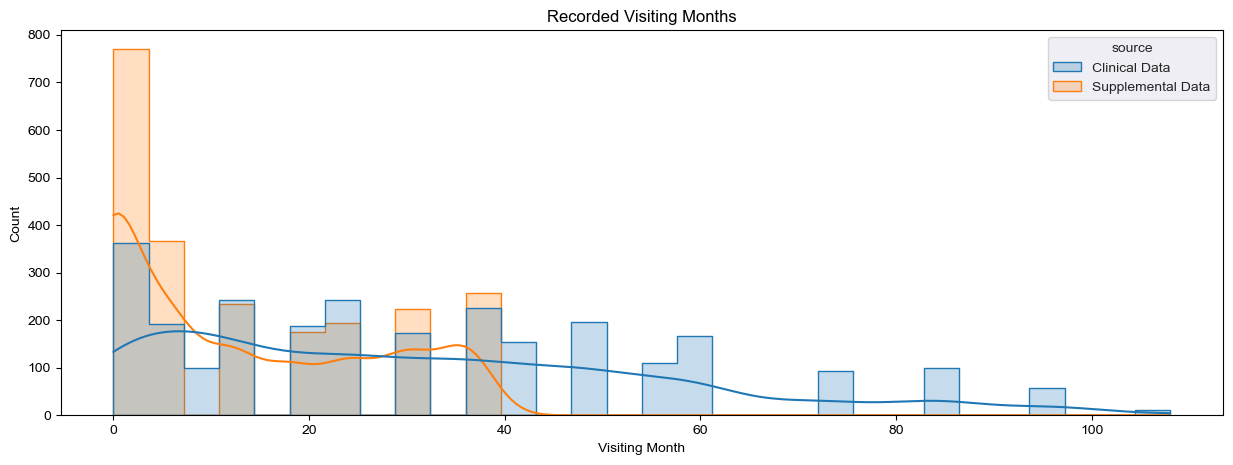

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sns.set_style('dark')
sns.histplot(data=combined_data, x='visit_month', hue='source', kde=True, ax=ax, element='step')
ax.set_title('Recorded Visiting Months')
ax.set_ylabel('Count')
ax.set_xlabel('Visiting Month');

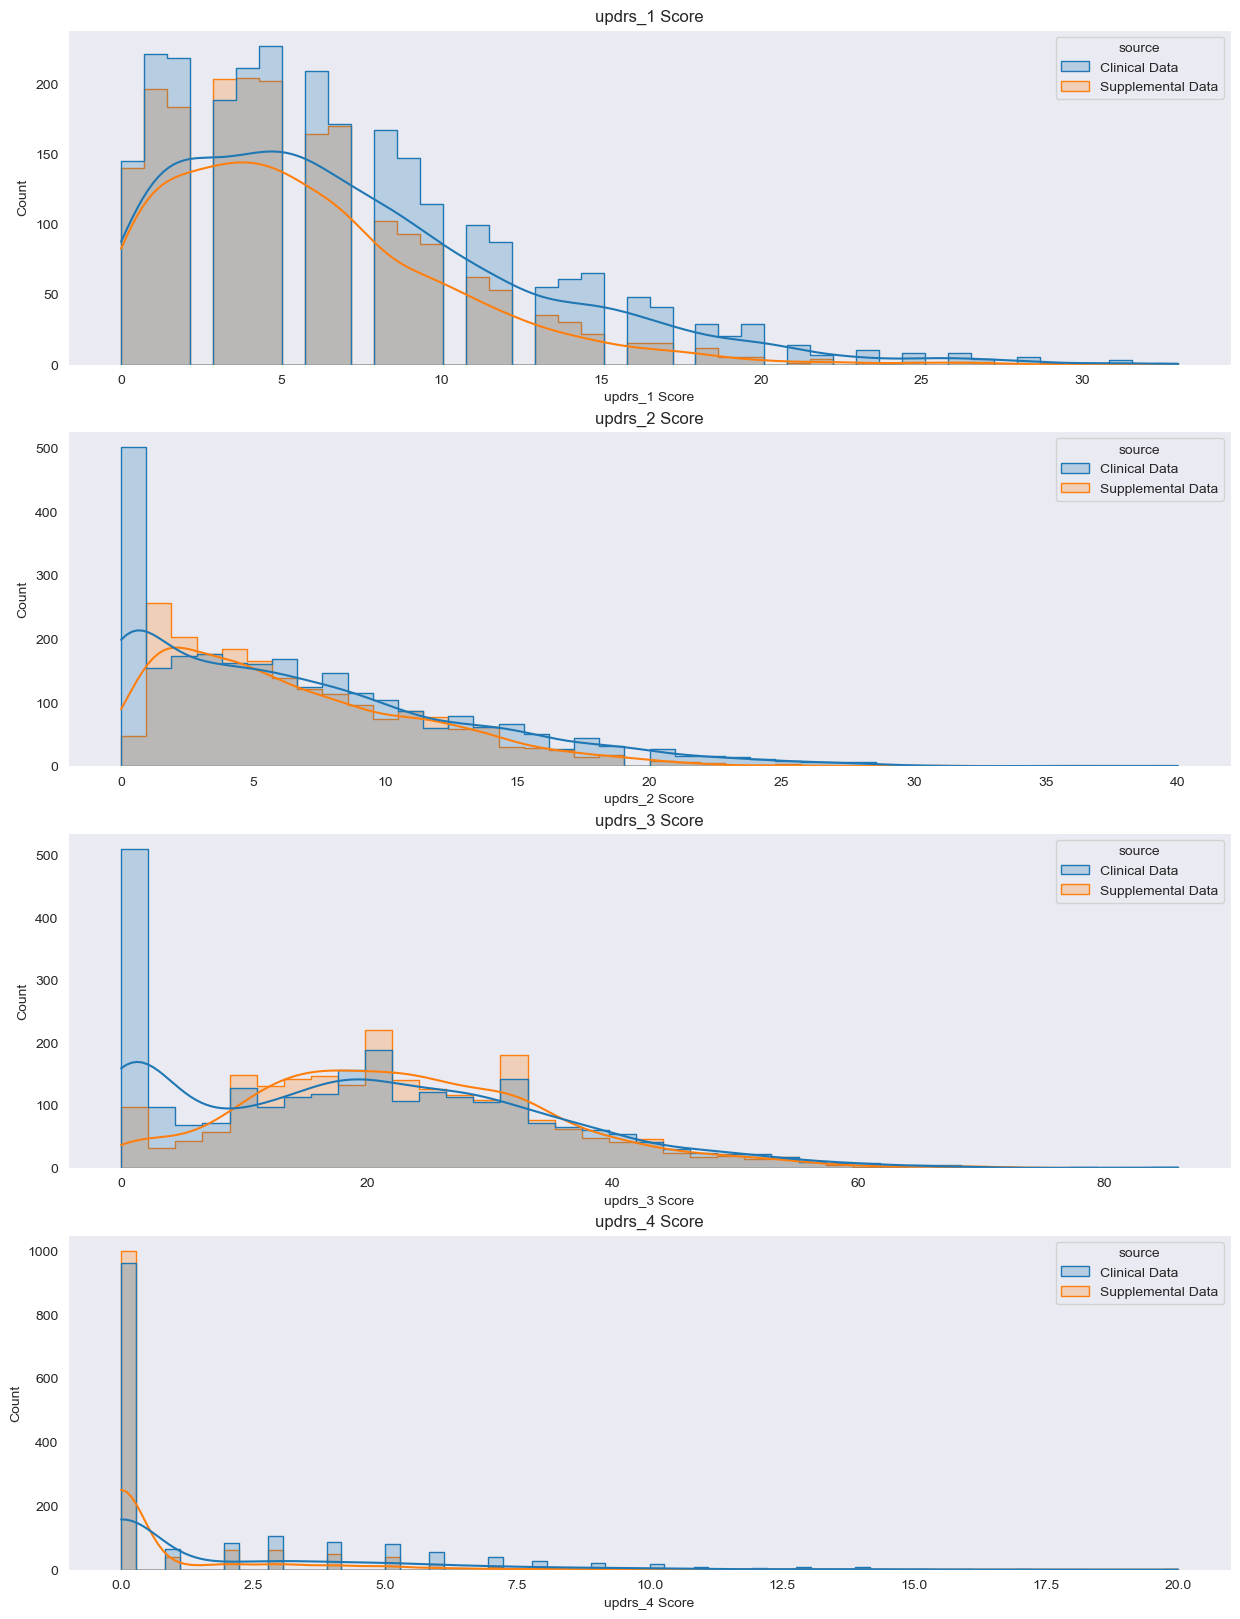

In [26]:
cols = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,20))
sns.set_style('dark')

for x, col in enumerate(cols):
    ax = axs[x]
    sns.histplot(data=combined_data, x=col, hue='source', kde=True, ax=ax, element='step')
    ax.set_title(f'{col} Score')
    ax.set_ylabel('Count')
    ax.set_xlabel(f'{col} Score')

UPDRS_1 and UPDRS_4 are similarly distributed across clincal data and supplemental data, while UPDRS_2 and UPDRS_3 scores are not. UPDRS_2 and UPDRS_3 scores have a much higher percentage of '0' in "clinical data". Since the two datasets are so different (in both score distribution, duration followed, and frequency of follow-up visits), should we be combining them and training a model on the combined data? My intution tells me that a model should only be trained on the much more complete "clinical" dataset.

Let's also take a statistical look at the proteomic data:

In [27]:
# taking a quick look at the protein data
train_proteins.describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,232741.0,2.609920e+01,2.287472e+01,0.0000,6.0,24.0,48.0,108.0
patient_id,232741.0,3.259388e+04,1.860848e+04,55.0000,16566.0,29313.0,49995.0,65043.0
NPX,232741.0,2.712077e+06,2.224155e+07,84.6082,29464.4,113556.0,563894.0,613851000.0


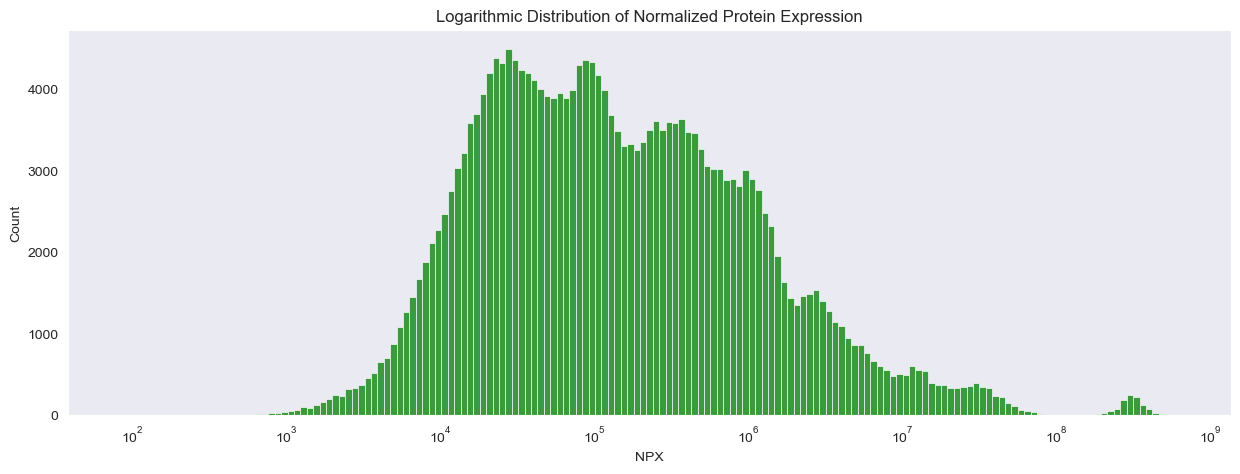

In [28]:
data = train_proteins['NPX']
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(15,5))
sns.histplot(data, ax=ax, log_scale=True, color='g')
ax.set_title('Logarithmic Distribution of Normalized Protein Expression');

In [29]:
# peptide data
train_peptides.describe().T

,count,mean,std,min,25%,50%,75%,max
visit_month,981834.0,26.105061,2.291390e+01,0.0000,6.00,24.0,48.00,108.0
patient_id,981834.0,32603.465361,1.860593e+04,55.0000,16566.00,29313.0,49995.00,65043.0
PeptideAbundance,981834.0,642890.245933,3.377989e+06,10.9985,28174.25,74308.3,221338.75,178752000.0


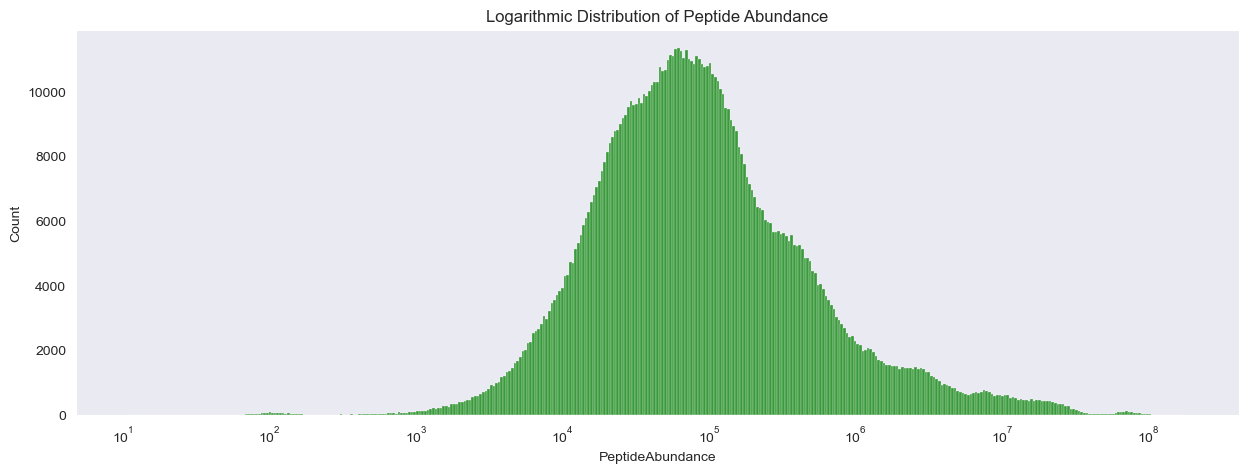

In [30]:
data = train_peptides['PeptideAbundance']
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(15,5))
sns.histplot(data, ax=ax, log_scale=True, color='g')
ax.set_title('Logarithmic Distribution of Peptide Abundance');

The distributions appear to be normal - nothing stands out here as odd.

Let's see if there is an overall trend with the UPDRS scores over time (visitations). One would expect worsening (increasing) scores with disease progression.

NameError: name 'train_clinical_copy' is not defined

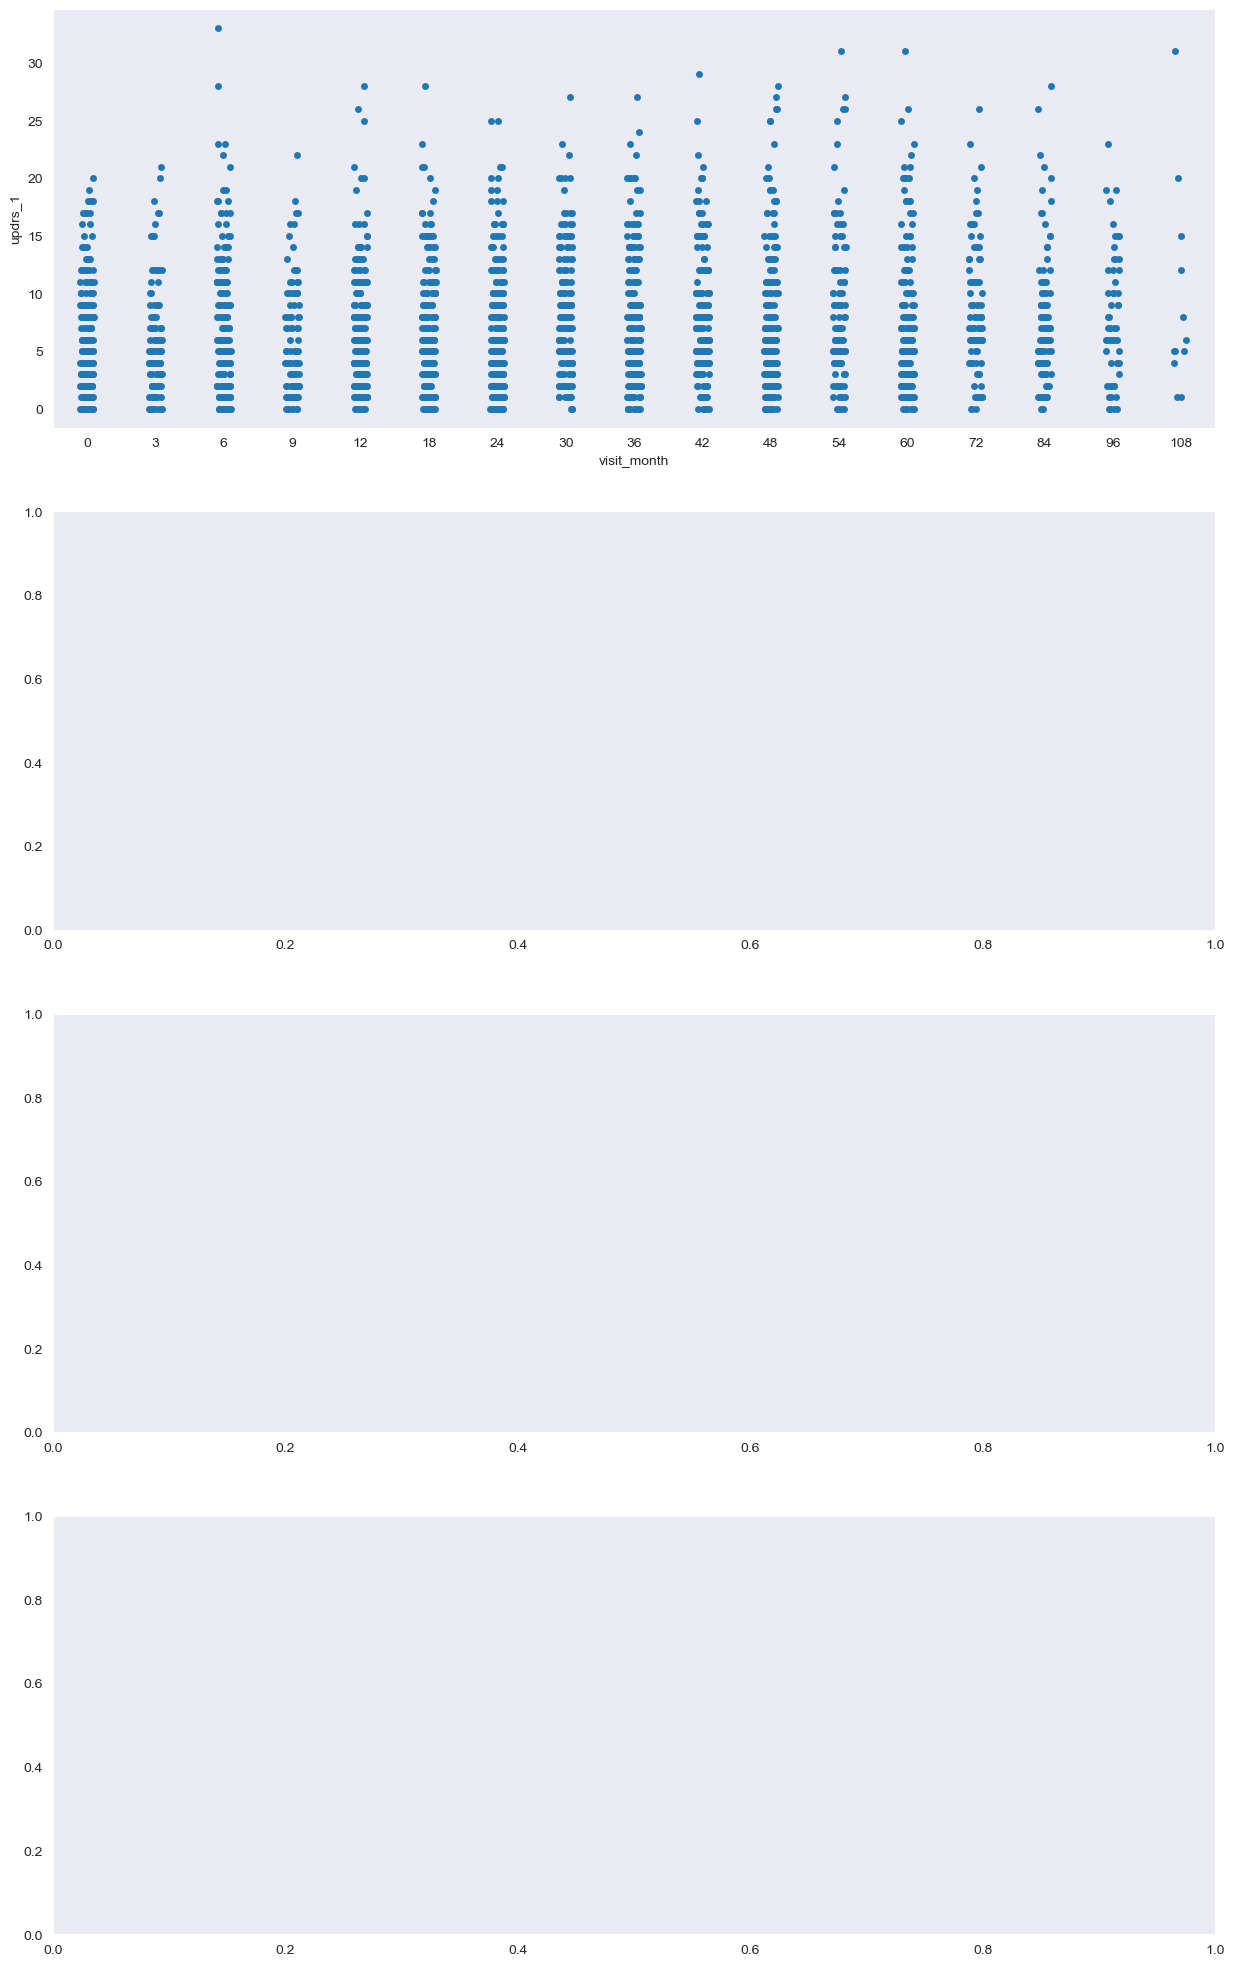

In [31]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,25))
cols = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

for i, col in enumerate(cols):
    ax=axs[i]
    sns.stripplot(data=train_clinical, x='visit_month', y=col, ax=ax)
    sns.pointplot(data=train_clinical_copy, x='visit_month', y=col, color='r', ax=ax, linestyles=':');


The proteomic data trend is not overly encouraging, as it shows relatively little trend in disease progression, as one would expect with Parkinson's, i.e. worsening symptoms over time showing increasing UPDRS scores. Here we see that there is only a slight upward trend across all the scores. 

What if we combine all four UPDRS scores?

In [ ]:
train_clinical['updrs_total'] = train_clinical['updrs_1']+train_clinical['updrs_2']+train_clinical['updrs_3']+train_clinical['updrs_4']

In [ ]:
train_clinical.head()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sns.boxplot(data=train_clinical, x='visit_month', y='updrs_total', ax=ax);

Slightly better, perhaps? We see an upward trend of the total UPDRS score over 108 months of follow-up, albeit not a very striking one. But understanding that PD is a slow progressing disease, this is more or less understandable, maybe even expected. 

Let's now look at the Protein Data over time. We'll convert NPX to natural log since the dataset range is too wide otherwise.

In [ ]:
train_proteins['log(NPX)'] = np.log(train_proteins['NPX'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

sns.boxplot(data=train_proteins, x='visit_month', y='log(NPX)', ax=ax);

This likely indicates that the total protein expressed (NPX) shows very little correlation with disease progression, but maybe certain types of peptides and their amounts can be telling? That is for our trained models to find out. At this point, I have a good understanding of the datasets and their pertaining information. My next steps are:
1) Drop the "medication status" column. 
2) Decide whether the "supplemental" data is useful, and whether to include it. 
3) Take care of the NaN values. 
4) Reorganize the data for training the models. 